In [1]:
# For loading and processing images
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# For image visualization (optional)
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
class PipelineDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Correcting the paths to reflect the actual structure
        leak_folder = os.path.join(root_dir, 'Leak', 'channel1')
        non_leak_folder = os.path.join(root_dir, 'Non Leak', 'channel1')
        
        # Class 1 for Leak
        for img_name in os.listdir(leak_folder):
            self.image_paths.append(os.path.join(leak_folder, img_name))
            self.labels.append(1)  # Leak = 1
        
        # Class 0 for Non-Leak
        for img_name in os.listdir(non_leak_folder):
            self.image_paths.append(os.path.join(non_leak_folder, img_name))
            self.labels.append(0)  # Non-Leak = 0
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Open as RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations for the images (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for CNN input
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load the dataset with the correct root directory
dataset = PipelineDataset(root_dir='E:/Pipeline Dataset/Pipeline Dataset/CWT RGB/CWT Gas_13Bar', transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
from torchvision.models import resnet18, ResNet18_Weights

# Load the pre-trained ResNet18 model with the updated weights parameter
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to output 2 classes (Leak, Non-Leak)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Leak and Non-Leak

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train the final layer

# Summary of the model
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Define the training function
def train_model(model, criterion, optimizer, dataloader, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total = 0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(dataloader)
        accuracy = correct_predictions / total
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

# Train the model using the training data
train_model(model, criterion, optimizer, train_loader, num_epochs=5)


Epoch 1/5, Loss: 0.4917, Accuracy: 0.7674
Epoch 2/5, Loss: 0.2972, Accuracy: 0.9410
Epoch 3/5, Loss: 0.1949, Accuracy: 0.9583
Epoch 4/5, Loss: 0.1371, Accuracy: 0.9896
Epoch 5/5, Loss: 0.1109, Accuracy: 0.9861


In [5]:
# Function to evaluate the model on the test set
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct_predictions / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model using the test data
evaluate_model(model, test_loader)


Test Accuracy: 1.0000


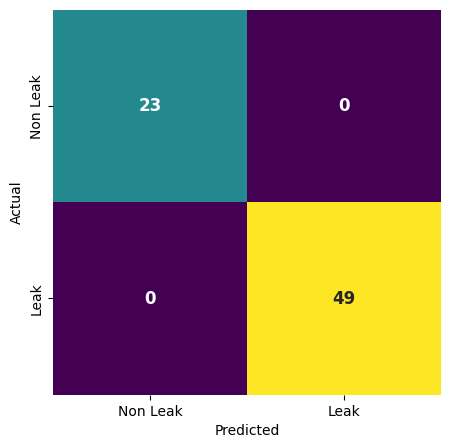

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are already obtained (from the test loader)
# y_pred, y_true = get_predictions(model, test_loader) # from your previous code

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"weight": "bold", "size": 12}, cbar=False)

# Modify the tick labels to display "Non Leak" and "Leak"
plt.xticks(ticks=[0.5, 1.5], labels=["Non Leak", "Leak"])
plt.yticks(ticks=[0.5, 1.5], labels=["Non Leak", "Leak"])

# Add axis labels
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Show the plot
plt.show()


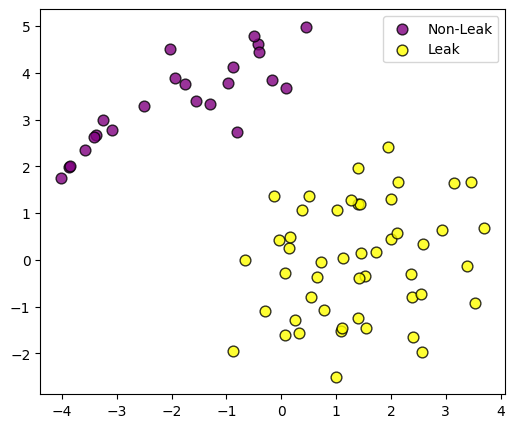

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming features and labels are already extracted as in your code

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Define custom colors for Non-Leak and Leak
colors = ['purple', 'yellow']

# Plot t-SNE results with improved visualization
plt.figure(figsize=(6, 5))

# Plot Non-Leak data points (label 0)
plt.scatter(tsne_results[labels == 0, 0], 
            tsne_results[labels == 0, 1], 
            label='Non-Leak', 
            color=colors[0], 
            s=60,  # Increase marker size
            edgecolor='k',  # Add black edges to points
            alpha=0.8)

# Plot Leak data points (label 1)
plt.scatter(tsne_results[labels == 1, 0], 
            tsne_results[labels == 1, 1], 
            label='Leak', 
            color=colors[1], 
            s=60,  # Increase marker size
            edgecolor='k',  # Add black edges to points
            alpha=0.8)


# Add a legend to indicate which class corresponds to which color
plt.legend()

# Display the plot
plt.show()


Epoch 1/10, Train Loss: 0.0182, Train Acc: 1.0000, Val Loss: 0.0135, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0189, Train Acc: 1.0000, Val Loss: 0.0117, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0189, Train Acc: 1.0000, Val Loss: 0.0115, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0200, Train Acc: 1.0000, Val Loss: 0.0105, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0180, Train Acc: 1.0000, Val Loss: 0.0101, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0133, Train Acc: 1.0000, Val Loss: 0.0094, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0135, Train Acc: 1.0000, Val Loss: 0.0090, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0182, Train Acc: 1.0000, Val Loss: 0.0087, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0147, Train Acc: 1.0000, Val Loss: 0.0085, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0096, Train Acc: 1.0000, Val Loss: 0.0081, Val Acc: 1.0000


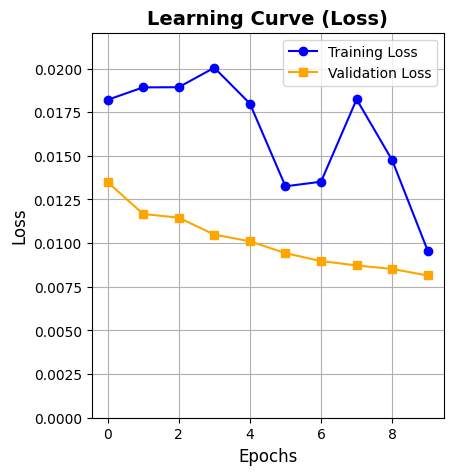

In [50]:
import matplotlib.pyplot as plt

# Assuming you have the train_losses and val_losses after training
# Train the model and collect losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=10)

# Plot learning curve for Loss
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)

plt.plot(train_losses, label='Training Loss', color='blue', marker='o')  # Add color and marker
plt.plot(val_losses, label='Validation Loss', color='orange', marker='s')  # Add color and marker
plt.title('Learning Curve (Loss)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Set y-axis limits starting from 0 to improve clarity of the loss reduction
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)

# Add grid for better readability
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()


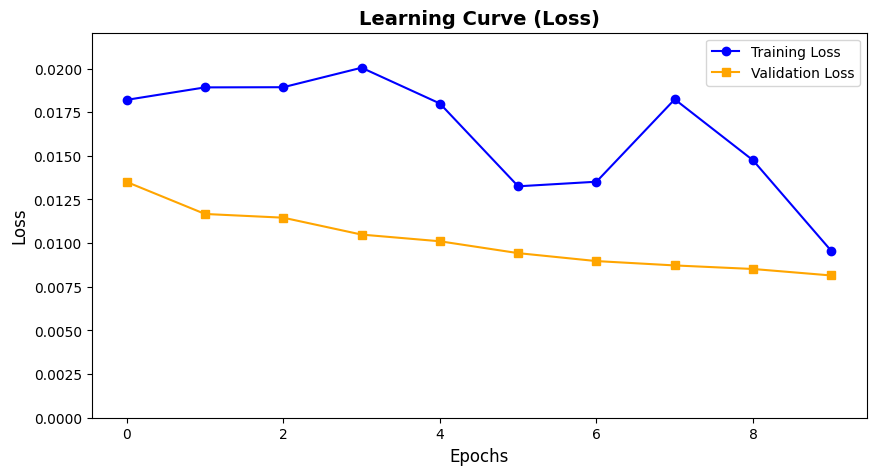

In [53]:
# Plot learning curve for Loss
plt.figure(figsize=(10, 5))


plt.plot(train_losses, label='Training Loss', color='blue', marker='o')  # Add color and marker
plt.plot(val_losses, label='Validation Loss', color='orange', marker='s')  # Add color and marker
plt.title('Learning Curve (Loss)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Set y-axis limits starting from 0 to improve clarity of the loss reduction
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)

# Add grid for better readability
#plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

Epoch 1/10, Train Loss: 0.0149, Train Acc: 1.0000, Val Loss: 0.0083, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0088, Train Acc: 1.0000, Val Loss: 0.0081, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0110, Train Acc: 1.0000, Val Loss: 0.0073, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0071, Train Acc: 1.0000, Val Loss: 0.0071, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0110, Train Acc: 1.0000, Val Loss: 0.0069, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0084, Train Acc: 1.0000, Val Loss: 0.0070, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0081, Train Acc: 1.0000, Val Loss: 0.0068, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0071, Train Acc: 1.0000, Val Loss: 0.0066, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0116, Train Acc: 1.0000, Val Loss: 0.0062, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0116, Train Acc: 1.0000, Val Loss: 0.0067, Val Acc: 1.0000


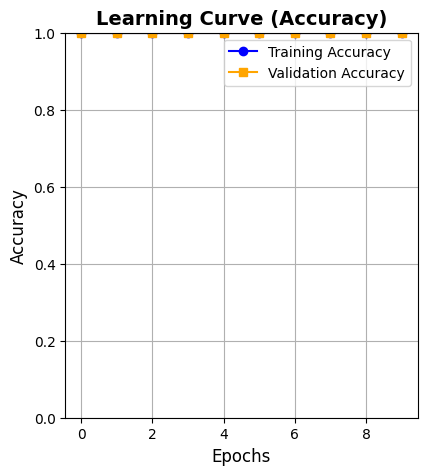

In [54]:
import matplotlib.pyplot as plt

# Assuming you have the train_accuracies and val_accuracies after training
# Train the model and collect losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=10)

# Plot learning curve for Accuracy
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 2)

plt.plot(train_accuracies, label='Training Accuracy', color='blue', marker='o')  # Add color and marker
plt.plot(val_accuracies, label='Validation Accuracy', color='orange', marker='s')  # Add color and marker
plt.title('Learning Curve (Accuracy)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Set y-axis limits between 0 and 1 for accuracy
plt.ylim(0, 1)

# Add grid for better readability
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()


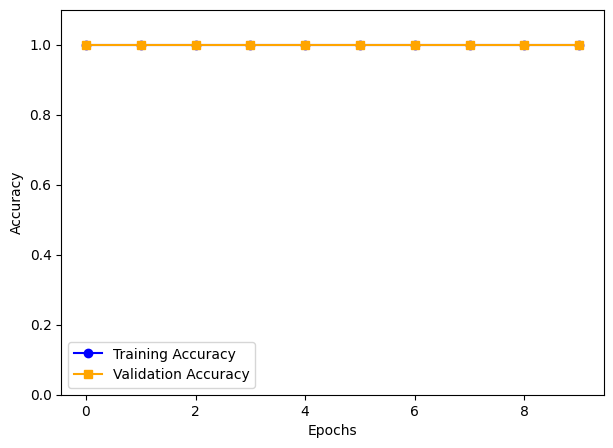

In [59]:
plt.figure(figsize=(7, 5))



plt.plot(train_accuracies, label='Training Accuracy', color='blue', marker='o')  # Add color and marker
plt.plot(val_accuracies, label='Validation Accuracy', color='orange', marker='s')  # Add color and marker
#plt.title('Learning Curve (Accuracy)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set y-axis limits between 0 and 1 for accuracy
plt.ylim(0, 1.1)

# Add grid for better readability

# Add a legend
plt.legend()

# Show the plot
plt.show()

Epoch 1/10, Train Loss: 0.0261, Train Acc: 1.0000, Val Loss: 0.0254, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0260, Train Acc: 0.9965, Val Loss: 0.0216, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0209, Train Acc: 1.0000, Val Loss: 0.0191, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0316, Train Acc: 0.9931, Val Loss: 0.0206, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0250, Train Acc: 1.0000, Val Loss: 0.0162, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0214, Train Acc: 1.0000, Val Loss: 0.0159, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0255, Train Acc: 1.0000, Val Loss: 0.0154, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0148, Train Acc: 1.0000, Val Loss: 0.0147, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0191, Train Acc: 1.0000, Val Loss: 0.0141, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0160, Train Acc: 1.0000, Val Loss: 0.0126, Val Acc: 1.0000


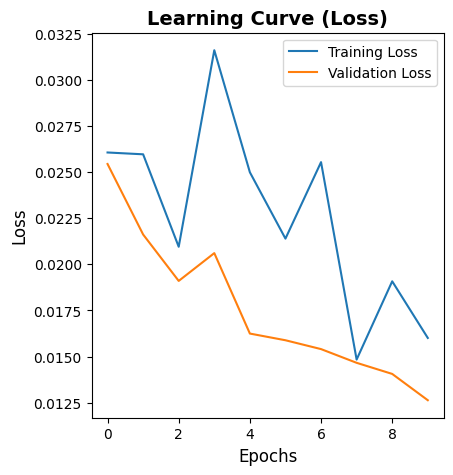

In [47]:
import matplotlib.pyplot as plt

# Train the model and collect losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=10)

# Plot learning curve for Loss
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curve (Loss)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()



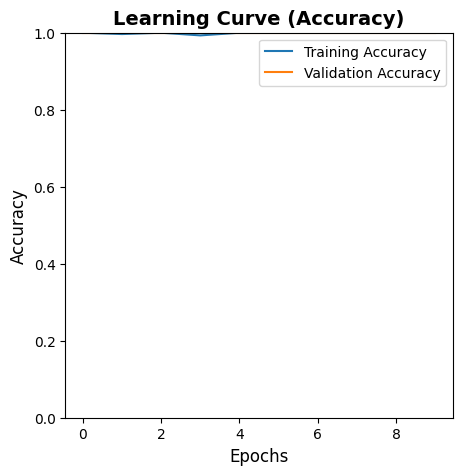

In [49]:
import matplotlib.pyplot as plt

# Assuming you already have train_accuracies and val_accuracies lists

# Create the figure for the accuracy plot
plt.figure(figsize=(5, 5))

# Plot training and validation accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

# Set y-axis limits from 0 to 1
plt.ylim(0, 1)

# Add labels and title
plt.title('Learning Curve (Accuracy)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Add a legend
plt.legend()

# Display the plot
plt.show()


In [44]:
from sklearn.metrics import classification_report

# Function to get predictions and true labels from the test loader
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

# Get predictions and true labels for the test set
y_pred, y_true = get_predictions_and_labels(model, test_loader)


In [46]:
# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['Non-Leak', 'Leak'])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Non-Leak       1.00      1.00      1.00        23
        Leak       1.00      1.00      1.00        49

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



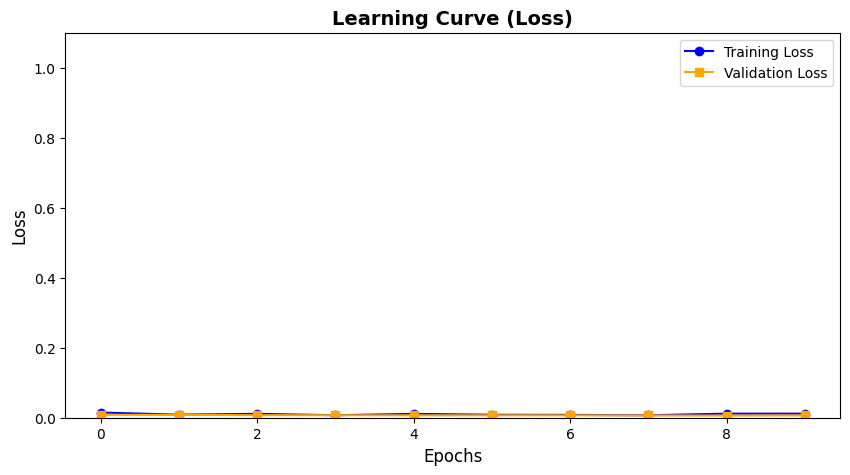

In [55]:
# Plot learning curve for Loss
plt.figure(figsize=(10, 5))


plt.plot(train_losses, label='Training Loss', color='blue', marker='o')  # Add color and marker
plt.plot(val_losses, label='Validation Loss', color='orange', marker='s')  # Add color and marker
plt.title('Learning Curve (Loss)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Set y-axis limits starting from 0 to improve clarity of the loss reduction
plt.ylim(0, max(max(train_accuracies), max(val_accuracies)) * 1.1)

# Add grid for better readability
#plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and initializations
T = 0.01
Q = 0.05 * np.array([
    [T**5 / 20, T**4 / 8, T**3 / 6],
    [T**4 / 8, T**3 / 3, T**2 / 2],
    [T**3 / 6, T**2 / 2, T]
])
R = 0.01
A = np.array([[1, T, T**2 / 2], [0, 1, T], [0, 0, 1]])
H = np.array([0, 0, 1])
num_steps = 100

# Step 1: Simulate x_k and z_k
np.random.seed(0)
x_true = np.zeros((3, num_steps))
z_k = np.zeros(num_steps)
for k in range(1, num_steps):
    x_true[:, k] = A @ x_true[:, k-1] + np.random.multivariate_normal([0, 0, 0], Q)
    z_k[k] = H @ x_true[:, k] + np.random.normal(0, np.sqrt(R))

# Step 2: Kalman Filter to estimate x_k
x_hat = np.zeros((3, num_steps))
P = np.eye(3)
P_trace = np.zeros((3, num_steps))
for k in range(1, num_steps):
    x_hat_pred = A @ x_hat[:, k-1]
    P_pred = A @ P @ A.T + Q
    K = P_pred @ H.T / (H @ P_pred @ H.T + R)
    x_hat[:, k] = x_hat_pred + K * (z_k[k] - H @ x_hat_pred)
    P = (np.eye(3) - np.outer(K, H)) @ P_pred
    P_trace[:, k] = np.diag(P)



Text(0.5, 1.0, 'Estimation Error $e_k$')

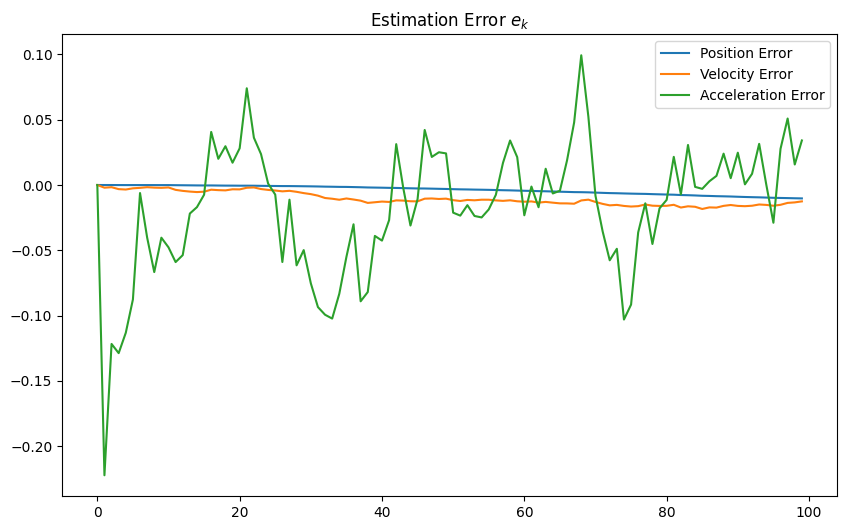

In [7]:
# Step 3: Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_true[0, :] - x_hat[0, :], label="Position Error")
plt.plot(x_true[1, :] - x_hat[1, :], label="Velocity Error")
plt.plot(x_true[2, :] - x_hat[2, :], label="Acceleration Error")
plt.legend(); plt.title("Estimation Error $e_k$")



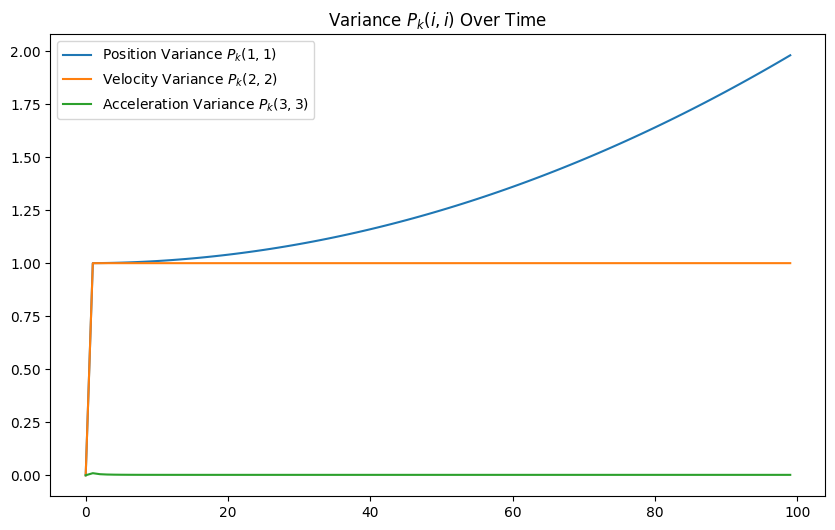

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(P_trace[0, :], label="Position Variance $P_k(1,1)$")
plt.plot(P_trace[1, :], label="Velocity Variance $P_k(2,2)$")
plt.plot(P_trace[2, :], label="Acceleration Variance $P_k(3,3)$")
plt.legend(); plt.title("Variance $P_k(i,i)$ Over Time")

plt.show()

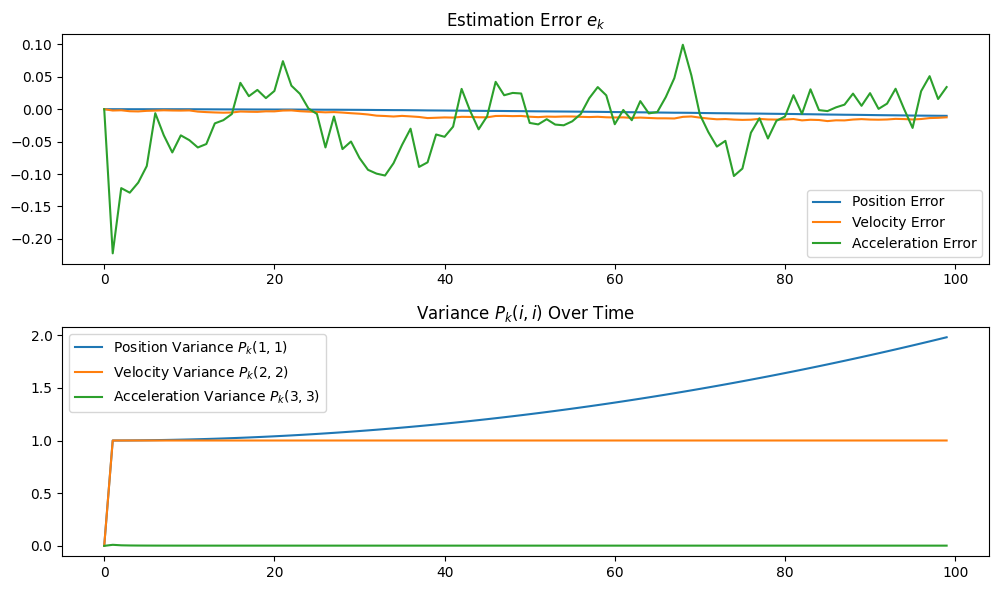

Final Estimation Errors:
Position Error: -0.010263609626581294
Velocity Error: -0.012534872491362939
Acceleration Error: 0.03411598297584474

Final Variances (Covariance Diagonal):
P_k(1,1) - Position Variance: 1.9801327868274234
P_k(2,2) - Velocity Variance: 1.0000995123753176
P_k(3,3) - Acceleration Variance: 0.002


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and initializations
T = 0.01
Q = 0.05 * np.array([
    [T**5 / 20, T**4 / 8, T**3 / 6],
    [T**4 / 8, T**3 / 3, T**2 / 2],
    [T**3 / 6, T**2 / 2, T]
])
R = 0.01
A = np.array([[1, T, T**2 / 2], [0, 1, T], [0, 0, 1]])
H = np.array([0, 0, 1])
num_steps = 100

# Step 1: Simulate x_k and z_k
np.random.seed(0)
x_true = np.zeros((3, num_steps))
z_k = np.zeros(num_steps)
for k in range(1, num_steps):
    x_true[:, k] = A @ x_true[:, k-1] + np.random.multivariate_normal([0, 0, 0], Q)
    z_k[k] = H @ x_true[:, k] + np.random.normal(0, np.sqrt(R))

# Step 2: Kalman Filter to estimate x_k
x_hat = np.zeros((3, num_steps))
P = np.eye(3)
P_trace = np.zeros((3, num_steps))
for k in range(1, num_steps):
    x_hat_pred = A @ x_hat[:, k-1]
    P_pred = A @ P @ A.T + Q
    K = P_pred @ H.T / (H @ P_pred @ H.T + R)
    x_hat[:, k] = x_hat_pred + K * (z_k[k] - H @ x_hat_pred)
    P = (np.eye(3) - np.outer(K, H)) @ P_pred
    P_trace[:, k] = np.diag(P)

# Step 3: Plot results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(x_true[0, :] - x_hat[0, :], label="Position Error")
plt.plot(x_true[1, :] - x_hat[1, :], label="Velocity Error")
plt.plot(x_true[2, :] - x_hat[2, :], label="Acceleration Error")
plt.legend(); plt.title("Estimation Error $e_k$")
plt.subplot(2, 1, 2)
plt.plot(P_trace[0, :], label="Position Variance $P_k(1,1)$")
plt.plot(P_trace[1, :], label="Velocity Variance $P_k(2,2)$")
plt.plot(P_trace[2, :], label="Acceleration Variance $P_k(3,3)$")
plt.legend(); plt.title("Variance $P_k(i,i)$ Over Time")
plt.tight_layout()
plt.show()

# Step 4: Print Final Mathematical Results
final_errors = x_true[:, -1] - x_hat[:, -1]
final_variances = P_trace[:, -1]
print("Final Estimation Errors:")
print(f"Position Error: {final_errors[0]}")
print(f"Velocity Error: {final_errors[1]}")
print(f"Acceleration Error: {final_errors[2]}\n")
print("Final Variances (Covariance Diagonal):")
print(f"P_k(1,1) - Position Variance: {final_variances[0]}")
print(f"P_k(2,2) - Velocity Variance: {final_variances[1]}")
print(f"P_k(3,3) - Acceleration Variance: {final_variances[2]}")
